In [1]:
from pathlib import Path
import pandas as pd

In [2]:
input_folder = Path('../output')
tags = ['cloudless', 'cloudy', 'paired']

In [3]:
def get_pkls_ended_with(folder, tag):
    res = []
    for file in folder.iterdir():
        if file.name.endswith(tag + '.pkl'):
            df = pd.read_pickle(file)
            scene = file.name.split('.')[0].split('_')[-2]
            df = df.assign(scene=scene)
            res.append(df)
    return res

def concat_dfs(dfs):
    return pd.concat(dfs).reset_index(drop=True)

pkls = {tag : concat_dfs(get_pkls_ended_with(input_folder, tag)) for tag in tags}
pkls[tags[0]].shape

ValueError: No objects to concatenate

In [ ]:
pkls[tags]

In [20]:
def save_pkls(pkls, output_dir='../streamlit/data/', splits=3):
    for tag, pkl in pkls.items():
        length = pkl.shape[0] // splits
        for s in range(splits):
            pkl.iloc[s*length:(s+1)*length].to_pickle(output_dir + tag + f"_{s}" + ".pkl")
save_pkls(pkls)

In [6]:
for col in pkls[tags[1]].columns:
    print(col)

0_traditional_contrast
0_michelson_contrast
0_rms_contrast
0_laplacian_blur
0_mean
0_median
0_p25
0_p75
0_std
1_traditional_contrast
1_michelson_contrast
1_rms_contrast
1_laplacian_blur
1_mean
1_median
1_p25
1_p75
1_std
2_traditional_contrast
2_michelson_contrast
2_rms_contrast
2_laplacian_blur
2_mean
2_median
2_p25
2_p75
2_std
3_traditional_contrast
3_michelson_contrast
3_rms_contrast
3_laplacian_blur
3_mean
3_median
3_p25
3_p75
3_std
4_traditional_contrast
4_michelson_contrast
4_rms_contrast
4_laplacian_blur
4_mean
4_median
4_p25
4_p75
4_std
5_traditional_contrast
5_michelson_contrast
5_rms_contrast
5_laplacian_blur
5_mean
5_median
5_p25
5_p75
5_std
6_traditional_contrast
6_michelson_contrast
6_rms_contrast
6_laplacian_blur
6_mean
6_median
6_p25
6_p75
6_std
7_traditional_contrast
7_michelson_contrast
7_rms_contrast
7_laplacian_blur
7_mean
7_median
7_p25
7_p75
7_std
8_traditional_contrast
8_michelson_contrast
8_rms_contrast
8_laplacian_blur
8_mean
8_median
8_p25
8_p75
8_std
9_traditio

In [6]:
cloudy = pkls[tags[1]]

crops = [f"b{b}_cloudy_crop_correlation_mse" for b in range(13)]
bands = [f"b{b}_cloudy_band_correlation_mse" for b in range(13)]

df = cloudy.copy()
for crop in crops:
    df['is_na'] = df[crop] == -1
    break
df = df[~df['is_na']]
df = df.transpose().loc[crops]
import matplotlib.pyplot as plt
indexes = df.reset_index()['index']
bs = indexes.apply(lambda x: x.split('_')[0])
df = df.transpose()
df = df.rename(columns=dict(zip(indexes, bs)))
df

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12
2,0.305075,0.326131,0.351372,0.339285,0.335528,0.301895,0.278757,0.307363,0.269148,0.691622,0.992697,0.361988,0.471893
3,0.681161,0.715051,0.733084,0.767674,0.718173,0.564851,0.510365,0.523719,0.489863,0.779259,0.969028,0.703579,0.809474
4,0.543895,0.568558,0.589564,0.589033,0.565162,0.480501,0.442157,0.466343,0.421344,0.839879,0.996204,0.496577,0.631169
5,0.474422,0.501688,0.527456,0.532488,0.511611,0.414289,0.371289,0.398701,0.350747,0.800824,0.992952,0.45985,0.595218
6,0.500989,0.532713,0.558382,0.559734,0.546929,0.479263,0.445849,0.47253,0.427632,0.836782,0.99311,0.489834,0.60473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94527,0.6323,0.68673,0.717729,0.719012,0.667273,0.544888,0.500196,0.50145,0.471677,0.691684,0.991895,0.527181,0.659848
94529,0.557989,0.505309,0.558461,0.565197,0.567061,0.569118,0.580522,0.599454,0.5956,0.778519,0.994589,0.464005,0.495332
94531,0.634579,0.680816,0.724264,0.722482,0.682734,0.606006,0.564762,0.559206,0.524047,0.731615,0.993567,0.535371,0.642277
94534,0.636489,0.684754,0.730666,0.734559,0.697829,0.612857,0.574009,0.567547,0.539707,0.735874,0.992161,0.609467,0.728332


In [7]:
cloudless, cloudy = pkls[tags[0]], pkls[tags[1]]

cloudless['type'] = 'cloudless'
cloudy['type'] = 'cloudy'

In [208]:
def turn_to_dist(cloudless, cloudy):
    properties = [f"{b}_{prop}" for b in range(13) for prop in ["mean", "median", "p25", "p75"]]
    df = pd.DataFrame()
    for attr in properties:
        df1 = pd.DataFrame()
        df1['value'] = cloudless[attr]
        df1['band'] = int(attr.split('_')[0])
        df1['measure'] = attr.split('_')[1]
        df1['type'] = 'cloudless'
        df2 = pd.DataFrame()
        df2['value'] = cloudy[attr]
        df2['band'] = int(attr.split('_')[0])
        df2['measure'] = attr.split('_')[1]
        df2['type'] = 'cloudy'
        union = pd.concat([df1, df2])
        df = pd.concat([df, union])
    return df
df = turn_to_dist(cloudless, cloudy)
df.head()

,value,band,measure,type
0,109.227219,0,mean,cloudless
1,72.753830,0,mean,cloudless
2,118.885086,0,mean,cloudless
3,113.019501,0,mean,cloudless
4,74.530991,0,mean,cloudless


In [9]:
import seaborn as sns
import plotly.express as px

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_36624\318905736.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


0.6 0.8999999999999999
120.33245980537339 53.249486989634015 value    67.082973
dtype: float64
1.7 2.0
119.81698751851069 53.19980960440025 value    66.617178
dtype: float64
2.8 3.0999999999999996
123.81110112121853 55.60392426486143 value    68.207177
dtype: float64
3.9 4.2
124.79194256399407 55.5970991114872 value    69.194843
dtype: float64
5.0 5.3
130.31303945419927 59.82357732176856 value    70.489462
dtype: float64
6.1 6.3999999999999995
142.3493785699175 68.46868256822509 value    73.880696
dtype: float64
7.2 7.5
146.0198646075735 70.742759678443 value    75.277105
dtype: float64
8.3 8.600000000000001
146.9560767928919 70.9757986037656 value    75.980278
dtype: float64
9.399999999999999 9.7
149.25650518299133 73.19208536069388 value    76.06442
dtype: float64
10.5 10.8
135.50244076581342 64.12659191876455 value    71.375849
dtype: float64
11.6 11.9
131.95035170298286 60.0809260630421 value    71.869426
dtype: float64
12.7 13.0
147.82267823143644 71.3927702559763 value    76.4299

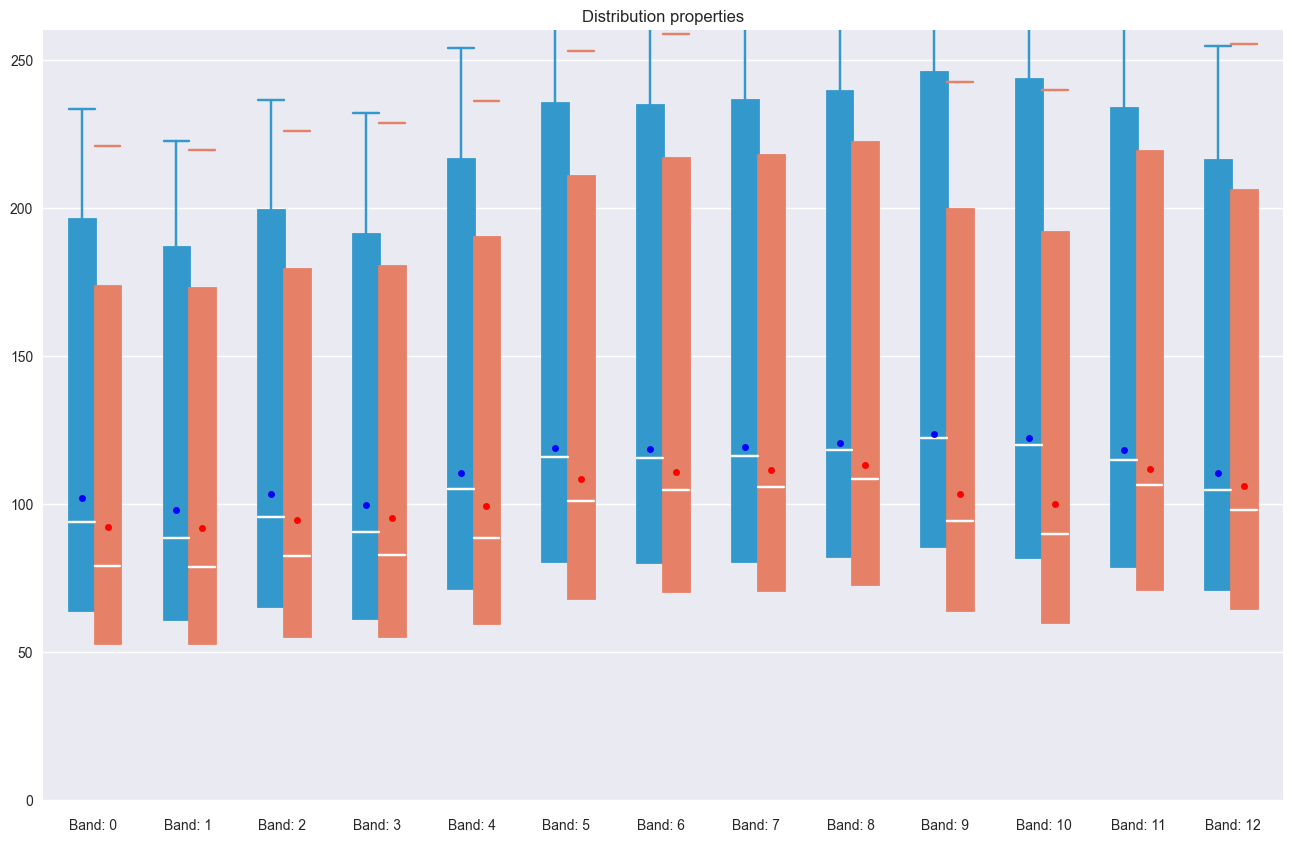

,value,band,measure,type
0,109.227219,0,mean,cloudless
1,72.753830,0,mean,cloudless
2,118.885086,0,mean,cloudless
3,113.019501,0,mean,cloudless
4,74.530991,0,mean,cloudless
...,...,...,...,...
94535,163.000000,12,p75,cloudy
94536,169.000000,12,p75,cloudy
94537,153.000000,12,p75,cloudy
94538,96.000000,12,p75,cloudy


In [221]:
from matplotlib.patches import Rectangle
import matplotlib.text as txt
plt.style.use('seaborn')
def to_kind_hist(df, width=0.3, spacing=0.5):
    fig, ax = plt.subplots(1,1, figsize=(16, 10))
    for band in range(13):
        df_band = df[df.band == band]
        df_band = df_band.groupby(by=['measure', 'type']).mean().drop('band', axis=1)
        ax.grid(zorder=-1)
        x_start = (band+ 1) * 2 * width + spacing * band
        print(x_start, x_start + width)
        rectless = Rectangle((x_start,df_band.loc['p25', 'cloudless']['value']), width, df_band.loc['p75', 'cloudless']['value'], color=(0.2,0.6, 0.8),lw = 2, zorder=2)
        recty = Rectangle((x_start + width ,df_band.loc['p25', 'cloudy']['value']), width, df_band.loc['p75', 'cloudy']['value'], color=(0.9,0.5, 0.4),lw = 2, zorder=2)
        ax.plot([x_start, x_start + width], [df_band.loc['median', 'cloudless']] * 2, color=(1,1, 1), zorder=3)
        ax.plot([x_start, x_start + width], [df_band.loc['p75', 'cloudless'] + 1.5 * (df_band.loc['p75', 'cloudless'] - df_band.loc['p25', 'cloudless'])] * 2, color=(0.2,0.6, 0.8), zorder=3)
        ax.plot([x_start + width/2, x_start + width/2], [df_band.loc['p75', 'cloudless'], df_band.loc['p75', 'cloudless'] + 1.5 * (df_band.loc['p75', 'cloudless'] - df_band.loc['p25', 'cloudless'])], color=(0.2,0.6, 0.8), zorder=3)
        ax.plot([x_start, x_start + width], [df_band.loc['p25', 'cloudless'] - 1.5 * (df_band.loc['p75', 'cloudless'] - df_band.loc['p25', 'cloudless'])] * 2, color=(0.2,0.6, 0.8), zorder=3)
        ax.plot([x_start + width, x_start + width * 2], [df_band.loc['median', 'cloudy']] * 2, color=(1,1, 1), zorder=3)
        ax.plot([x_start + width, x_start + width * 2], [df_band.loc['p75', 'cloudy'] + 1.5 * (df_band.loc['p75', 'cloudy'] - df_band.loc['p25', 'cloudy'])] * 2, color=(0.9,0.5, 0.4), zorder=3)
        print(df_band.loc['p75', 'cloudy']['value'], df_band.loc['p25', 'cloudy']['value'], (df_band.loc['p75', 'cloudy'] - df_band.loc['p25', 'cloudy']))
        ax.plot([x_start + width, x_start + width * 2], [df_band.loc['p25', 'cloudy'] - 1.5 * (df_band.loc['p75', 'cloudy'] - df_band.loc['p25', 'cloudy'])] * 2, color=(0.9,0.5, 0.4), zorder=3)
        ax.plot((x_start + width/2), df_band.loc['mean', 'cloudless'], 'bo', zorder=3, markersize=5)
        ax.plot((x_start + width/2 + width), df_band.loc['mean', 'cloudy'], '-ro', zorder=3, markersize=5)
        ax.text(x_start, -10, f"Band: {band}")
        ax.add_patch(rectless,)
        ax.add_patch(recty, )
    
    ax.set_title("Distribution properties")
    ax.get_xaxis().set_visible(False)
    plt.xlim([width, x_start + width * 3])
    plt.ylim([0, 260])
    plt.show()
    return df

to_kind_hist(df)

In [37]:
print(df[df.band.apply(lambda x: x == 0 or x ==1)].groupby(by=['measure', 'type', 'band']).mean().to_dict())

{'value': {('mean', 'cloudless', 0): 101.94383486317408, ('mean', 'cloudless', 1): 97.93806395106016, ('mean', 'cloudy', 0): 92.30875742593325, ('mean', 'cloudy', 1): 92.05808320970498, ('median', 'cloudless', 0): 93.85424159086101, ('median', 'cloudless', 1): 88.74899513433468, ('median', 'cloudy', 0): 79.06713031521049, ('median', 'cloudy', 1): 78.73362597842183, ('p25', 'cloudless', 0): 64.2585704463719, ('p25', 'cloudless', 1): 61.245858895705524, ('p25', 'cloudy', 0): 53.249486989634015, ('p25', 'cloudy', 1): 53.19980960440025, ('p75', 'cloudless', 0): 131.9348556166702, ('p75', 'cloudless', 1): 125.75152052041464, ('p75', 'cloudy', 0): 120.33245980537339, ('p75', 'cloudy', 1): 119.81698751851069}}
